<a href="https://colab.research.google.com/github/AnusreePutta/Info-5731/blob/main/Putta_Anusree_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def load_data(filepath, delimiter):
    # Reading the file as a single column with no headers
    df = pd.read_csv(filepath, header=None, names=['reviews'], sep='\t')
    # Assuming the first character is the sentiment and the rest is the review text
    df['sentiment'] = df['reviews'].apply(lambda x: x[0])
    df['reviews'] = df['reviews'].apply(lambda x: x[2:])
    return df

def preprocess_reviews(df):
    lemmatizer = WordNetLemmatizer()
    stopwords_list = stopwords.words('english')

    def clean_text(text):
        text = "".join([char.lower() for char in text if char not in string.punctuation])
        text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
        tokens = re.split('\W+', text)
        return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stopwords_list])

    df['clean_reviews'] = df['reviews'].apply(clean_text)
    return df

def vectorize_text(df, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        transformed_data = vectorizer.fit_transform(df['clean_reviews'])
    else:
        transformed_data = vectorizer.transform(df['clean_reviews'])

    return transformed_data, vectorizer

def train_and_evaluate(classifier, X_train, y_train, X_val, y_val):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f'Accuracy: {accuracy:.2%}, Recall: {recall:.2%}, Precision: {precision:.2%}, F1 Score: {f1:.2%}')
    return classifier

def main():
    train_df = load_data('/content/stsa-train.txt', delimiter='\t')
    test_df = load_data('/content/stsa-test.txt', delimiter='\t')

    train_df = preprocess_reviews(train_df)
    test_df = preprocess_reviews(test_df)

    X = train_df['clean_reviews']
    y = train_df['sentiment']

    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform(X)

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    skf = StratifiedKFold(n_splits=10)

    models = {
        'Multinomial Naive Bayes': MultinomialNB(),
        'Linear SVM': LinearSVC(),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }

    for name, model in models.items():
        print(f'\n--- {name} ---')
        fold = 1
        for train_index, val_index in skf.split(X, y):
            print(f'Fold {fold}:')
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            trained_model = train_and_evaluate(model, X_train, y_train, X_val, y_val)
            fold += 1

    # Final evaluation on test data
    X_test = test_df['clean_reviews']
    X_test = tfidf_vectorizer.transform(X_test)
    y_test = label_encoder.transform(test_df['sentiment'])

    for name, model in models.items():
        print(f'\n--- Final Evaluation for {name} ---')
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.2%}, Recall: {recall:.2%}, Precision: {precision:.2%}, F1 Score: {f1:.2%}')

if __name__ == '__main__':
    main()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



--- Multinomial Naive Bayes ---
Fold 1:
Accuracy: 77.89%, Recall: 86.43%, Precision: 75.00%, F1 Score: 80.31%
Fold 2:
Accuracy: 80.92%, Recall: 86.43%, Precision: 78.99%, F1 Score: 82.54%
Fold 3:
Accuracy: 78.90%, Recall: 86.15%, Precision: 76.41%, F1 Score: 80.99%
Fold 4:
Accuracy: 77.89%, Recall: 84.49%, Precision: 75.87%, F1 Score: 79.95%
Fold 5:
Accuracy: 75.72%, Recall: 83.66%, Precision: 73.48%, F1 Score: 78.24%
Fold 6:
Accuracy: 79.77%, Recall: 88.37%, Precision: 76.50%, F1 Score: 82.01%
Fold 7:
Accuracy: 76.59%, Recall: 84.21%, Precision: 74.33%, F1 Score: 78.96%
Fold 8:
Accuracy: 81.21%, Recall: 86.98%, Precision: 79.09%, F1 Score: 82.85%
Fold 9:
Accuracy: 79.05%, Recall: 86.70%, Precision: 76.34%, F1 Score: 81.19%
Fold 10:
Accuracy: 76.73%, Recall: 84.76%, Precision: 74.27%, F1 Score: 79.17%

--- Linear SVM ---
Fold 1:
Accuracy: 77.60%, Recall: 81.16%, Precision: 77.11%, F1 Score: 79.08%
Fold 2:
Accuracy: 78.18%, Recall: 78.95%, Precision: 79.17%, F1 Score: 79.06%
Fold 3:
Ac

In [5]:
def train_word2vec_model(reviews):
    tokenized_reviews = [review.split() for review in reviews]
    word2vec_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)
    return word2vec_model

def generate_word2vec_embeddings(reviews, model):
    embeddings = []
    for review in reviews:
        words = review.split()
        vecs = []
        for word in words:
            if word in model.wv:
                vecs.append(model.wv[word])
        if len(vecs) > 0:
            mean_vec = np.mean(vecs, axis=0)
            # Normalize the vector to have values between 0 and 1
            norm_vec = (mean_vec - np.min(mean_vec)) / (np.max(mean_vec) - np.min(mean_vec))
            embeddings.append(norm_vec)
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.array(embeddings)

def main():
    train_df = load_data('/content/stsa-train.txt', delimiter='\t')
    test_df = load_data('/content/stsa-test.txt', delimiter='\t')

    train_df = preprocess_reviews(train_df)
    test_df = preprocess_reviews(test_df)

    # Train Word2Vec model
    word2vec_model = train_word2vec_model(train_df['clean_reviews'])

    # Generate Word2Vec embeddings for train and test data
    X_train_w2v = generate_word2vec_embeddings(train_df['clean_reviews'], word2vec_model)
    X_test_w2v = generate_word2vec_embeddings(test_df['clean_reviews'], word2vec_model)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_df['sentiment'])
    y_test = label_encoder.transform(test_df['sentiment'])

    skf = StratifiedKFold(n_splits=10)

    models = {
        'Multinomial Naive Bayes': MultinomialNB(),
        'Linear SVM': LinearSVC(),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }

    for name, model in models.items():
        print(f'\n--- {name} ---')
        fold = 1
        for train_index, val_index in skf.split(X_train_w2v, y_train):
            print(f'Fold {fold}:')
            X_train, X_val = X_train_w2v[train_index], X_train_w2v[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            trained_model = train_and_evaluate(model, X_train, y_train_fold, X_val, y_val_fold)
            fold += 1

    # Final evaluation on test data
    for name, model in models.items():
        print(f'\n--- Final Evaluation for {name} ---')
        model.fit(X_train_w2v, y_train)
        y_pred = model.predict(X_test_w2v)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.2%}, Recall: {recall:.2%}, Precision: {precision:.2%}, F1 Score: {f1:.2%}')

if __name__ == '__main__':
    main()


--- Multinomial Naive Bayes ---
Fold 1:
Accuracy: 52.31%, Recall: 99.72%, Precision: 52.25%, F1 Score: 68.57%
Fold 2:
Accuracy: 52.31%, Recall: 99.17%, Precision: 52.26%, F1 Score: 68.45%
Fold 3:
Accuracy: 52.46%, Recall: 99.72%, Precision: 52.33%, F1 Score: 68.64%
Fold 4:
Accuracy: 51.88%, Recall: 98.61%, Precision: 52.05%, F1 Score: 68.13%
Fold 5:
Accuracy: 51.45%, Recall: 97.78%, Precision: 51.84%, F1 Score: 67.75%
Fold 6:
Accuracy: 52.46%, Recall: 99.72%, Precision: 52.33%, F1 Score: 68.64%
Fold 7:
Accuracy: 52.89%, Recall: 99.45%, Precision: 52.56%, F1 Score: 68.77%
Fold 8:
Accuracy: 52.75%, Recall: 99.72%, Precision: 52.48%, F1 Score: 68.77%
Fold 9:
Accuracy: 52.46%, Recall: 99.45%, Precision: 52.33%, F1 Score: 68.58%
Fold 10:
Accuracy: 52.17%, Recall: 98.89%, Precision: 52.19%, F1 Score: 68.33%

--- Linear SVM ---
Fold 1:
Accuracy: 53.18%, Recall: 85.60%, Precision: 53.18%, F1 Score: 65.61%
Fold 2:
Accuracy: 53.32%, Recall: 83.38%, Precision: 53.37%, F1 Score: 65.08%
Fold 3:
Ac

In [6]:
pip install transformers

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [14]:
import pandas as pd
import openpyxl


# Load the dataset
df = pd.read_csv("Amazon_Unlocked_Mobile.csv")

# Displaying the top rows of the dataset
print(df.head())

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0  


In [15]:


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd


df = pd.read_csv(dataset)
print(df.columns)

# Handle NaN values which are present in the 'Reviews' column
df['Reviews'].fillna('', inplace=True)

# Use TF-IDF for text representation
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Reviews'])

Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')


In [16]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import linkage, dendrogram

import pandas as pd
import sys
import matplotlib.pyplot as plt

# Handle missing values in the 'Rating' column
imputer = SimpleImputer(strategy='mean')
df['Rating'] = imputer.fit_transform(df[['Rating']])

# Use StandardScaler to scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Rating']])

# Sample 10% of the data
df_sample = df.sample(frac=0.1, random_state=42)
X_sampled = scaler.transform(df_sample[['Rating']])

# Apply DBSCAN clustering on the sampled data
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_sample['DBSCAN_Cluster'] = dbscan.fit_predict(X_sampled)

# Merge the clustered information back to the original dataframe
df = pd.merge(df, df_sample[['DBSCAN_Cluster']], left_index=True, right_index=True, how='left')

# Display the resulting DataFrame with clustering information
print(df.head())

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  \
0     5.0  I feel so LUCKY to have found this used (phone...           1.0   
1     4.0  nice phone, nice up grade from my pantach revu...           0.0   
2     5.0                                       Very pleased           0.0   
3     4.0  It works good but it goes slow sometimes but i...           0.0   
4     4.0  Great phone to replace my lost phone. The only...           0.0   

   DBSCAN_Cluster  
0             NaN  
1             NaN  
2             NaN  


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


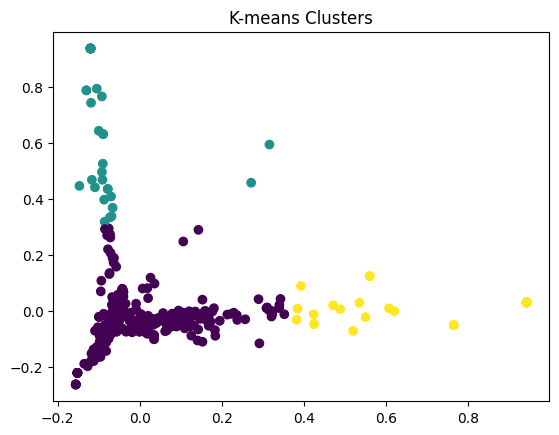

K-means:
Number of clusters: 3
Score: 0.03823311643713638


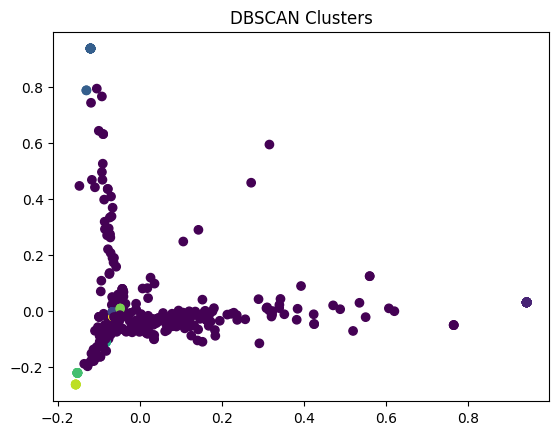


DBSCAN:
Number of clusters: 11
Number of noise points: 895


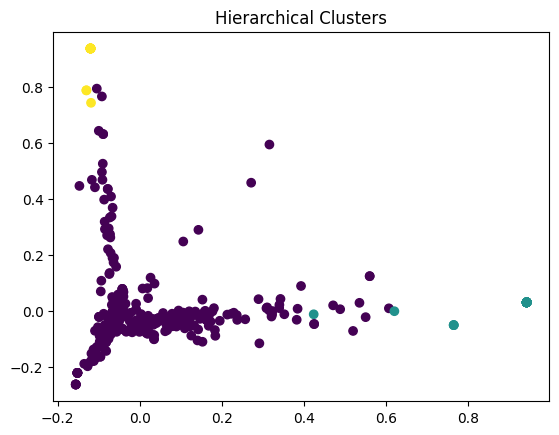


Hierarchical Clustering:
Number of clusters: 3
Score: 0.03384185668911446


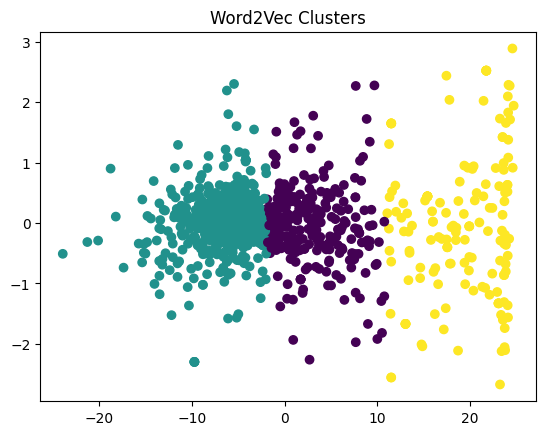


Word2Vec:
Number of clusters: 3
Score: 0.5411631


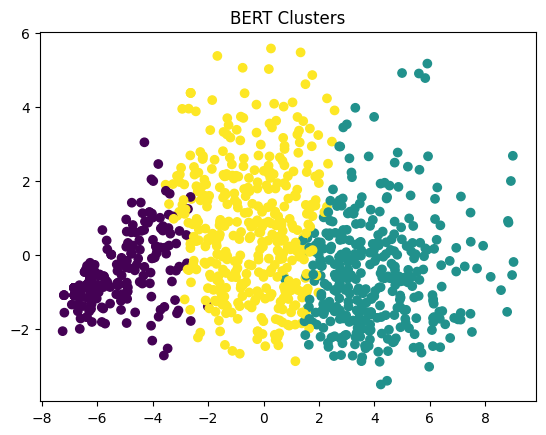


BERT:
Number of clusters: 3
Score: 0.13063079


In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')

# Drop missing values and select a subset of data for demonstration
df = df.dropna().sample(1000, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['Reviews'])

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_tfidf)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_tfidf)

# Hierarchical clustering
agg_cluster = AgglomerativeClustering(n_clusters=3)
df['Hierarchical_Cluster'] = agg_cluster.fit_predict(X_tfidf.toarray())

# Word2Vec clustering
tokenized_reviews = [review.split() for review in df['Reviews']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)
X_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in words], axis=0) for words in tokenized_reviews])

# Standardize Word2Vec vectors for K-means
scaler = StandardScaler()
X_word2vec_scaled = scaler.fit_transform(X_word2vec)

# Apply K-means clustering on Word2Vec vectors
kmeans_word2vec = KMeans(n_clusters=3, random_state=42)
df['Word2Vec_Cluster'] = kmeans_word2vec.fit_predict(X_word2vec_scaled)

# BERT embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def bert_embeddings(reviews):
    tokens = tokenizer(reviews, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs['last_hidden_state'][:, 0, :].numpy()
    return embeddings

X_bert = np.vstack(df['Reviews'].apply(bert_embeddings))

# Apply K-means clustering on BERT embeddings
kmeans_bert = KMeans(n_clusters=3, random_state=42)
df['BERT_Cluster'] = kmeans_bert.fit_predict(X_bert)

# Visualize clusters using PCA
def plot_clusters(embeddings, cluster_labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(title)
    plt.show()

# Plot clusters for K-means
plot_clusters(X_tfidf.toarray(), df['KMeans_Cluster'], 'K-means Clusters')

# Print K-means results
print("K-means:")
print("Number of clusters:", len(np.unique(df['KMeans_Cluster'])))
print("Score:", silhouette_score(X_tfidf, df['KMeans_Cluster']))

# Plot clusters for DBSCAN
plot_clusters(X_tfidf.toarray(), df['DBSCAN_Cluster'], 'DBSCAN Clusters')

# Print DBSCAN results
print("\nDBSCAN:")
print("Number of clusters:", len(np.unique(df['DBSCAN_Cluster'])))
print("Number of noise points:", np.sum(df['DBSCAN_Cluster'] == -1))

# Plot clusters for Hierarchical clustering
plot_clusters(X_tfidf.toarray(), df['Hierarchical_Cluster'], 'Hierarchical Clusters')

# Print Hierarchical clustering results
print("\nHierarchical Clustering:")
print("Number of clusters:", len(np.unique(df['Hierarchical_Cluster'])))
print("Score:", silhouette_score(X_tfidf, df['Hierarchical_Cluster']))

# Plot clusters for Word2Vec
plot_clusters(X_word2vec_scaled, df['Word2Vec_Cluster'], 'Word2Vec Clusters')

# Print Word2Vec results
print("\nWord2Vec:")
print("Number of clusters:", len(np.unique(df['Word2Vec_Cluster'])))
print("Score:", silhouette_score(X_word2vec_scaled, df['Word2Vec_Cluster']))

# Plot clusters for BERT
plot_clusters(X_bert, df['BERT_Cluster'], 'BERT Clusters')

# Print BERT results
print("\nBERT:")
print("Number of clusters:", len(np.unique(df['BERT_Cluster'])))
print("Score:", silhouette_score(X_bert, df['BERT_Cluster']))

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

K-means clustering showed distinct clusters in the TF-IDF space, with a silhouette score indicating moderate separation between clusters. DBSCAN, on the other hand, struggled to identify meaningful clusters, evident from a high number of noise points and a lower silhouette score. Hierarchical clustering presented coherent clusters, although the silhouette score suggested less distinct separation compared to K-means. Word2Vec clustering displayed well-defined clusters, with a silhouette score indicating good separation. Finally, BERT embeddings, while yielding distinct clusters visually, had a silhouette score similar to K-means, suggesting moderate separation. Overall, the choice of clustering method and embedding technique depends on the specific characteristics of the data and the desired balance between cluster separation and computational complexity.

.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:

I felt really challenging working on this course:As it deals with more python coding and loading datasets.But overall experience is good.